In [1]:
import random as rnd
import os
import time
import yaml

import pickle
import numpy as np 
import matplotlib.pyplot as plt
import numpyro
from numpyro.infer import Predictive
from numpyro.diagnostics import hpdi
numpyro.set_host_device_count(4)
import jax
import optax
from jax import random
import jax.numpy as jnp
import flax.linen as nn
import numpyro.distributions as npdist
from numpyro.infer import init_to_median, MCMC, NUTS

from priorCVAE.models import MLPDecoder
from priorCVAE.mcmc import run_mcmc_vae, vae_mcmc_inference_model, run_mcmc_gp, gp_mcmc_inference_model
from priorCVAE.priors import SquaredExponential, Matern52, GP
import priorCVAE.priors as priors
from priorCVAE.utility import load_model_params

import jax.config as config
config.update("jax_enable_x64", True)

In [2]:
# vae_model = "3tgjr5mg", cvae_model="qa1qdmjd"

vae_model_dir = "../arc_outputs/gp/3tgjr5mg/"
output_dir = "output_tex/"

true_ls = 0.3
kernel = Matern52()

x0 = 0
x1 = 1
n_data = 80

In [3]:
mcmc_args = {
        "num_warmup": 5000,
        "num_mcmc_samples": 50000,
        "num_chains": 3,
        "thinning": 1,
       }

In [4]:
x = jnp.linspace(x0, x1, n_data) 
mcmc_args["x"] = x

## Generate data for MCMC

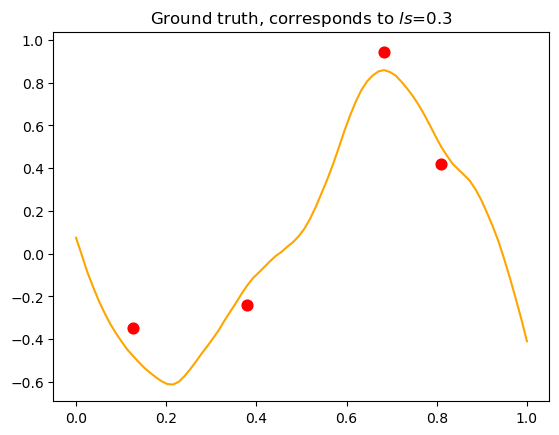

In [5]:
rng_key = random.PRNGKey(833)
rng_key_1, rng_key_2 = random.split(rng_key, 2)

kernel.lengthscale = true_ls
gp_predictive = Predictive(GP, num_samples=1)
draws = gp_predictive(rng_key_1, kernel=kernel, x=x, jitter=1e-6, noise=True)

gp_draw = draws['f'].T
y_draw = draws['y'].T

# indices of data points
obs_idx = jnp.array([10, 30, 54, 64])
y_obs = y_draw[obs_idx,0]
x_obs = x[np.array(obs_idx)]

# plt.figure(figsize=(10, 3))
plt.plot(x, gp_draw, label="ground truth", color="orange")
plt.scatter(x_obs, y_obs, color="red", label="observed data", s=60)
plt.title('Ground truth, corresponds to $ls$=' + str(true_ls))
plt.show()


In [6]:
# add data to args. This is used by MCMC.
mcmc_args["y_obs"] = y_obs
mcmc_args["obs_idx"] = obs_idx

## Load Prior{C}VAE model

In [7]:
cfg_path = os.path.join(vae_model_dir, "files", "config.yaml")
with open(cfg_path, 'r') as file:
    cfg_data = yaml.safe_load(file)

latent_dim = cfg_data["latent_dim"]["value"]
conditional = cfg_data["conditional"]["value"]
dec_activation_fn = cfg_data["dec_activation"]["value"]["_target_"]
dec_activation_fn = getattr(nn, dec_activation_fn.split(".")[-1])
kernel_vae = getattr(priors, cfg_data["data_generator"]["value"]["kernel"]["_target_"].split(".")[-1])

In [8]:
kernel_vae, conditional

(priorCVAE.priors.kernels.Matern52, False)

In [9]:
trained_decoder_params = load_model_params(os.path.join(vae_model_dir, "model"))["decoder"]

In [10]:
output_dim = trained_decoder_params["dec_out"]["bias"].shape[0]
hidden_dim = trained_decoder_params["dec_hidden_0"]["bias"].shape[0]
decoder = MLPDecoder(hidden_dim=hidden_dim, out_dim=output_dim, activations=dec_activation_fn)

## Run MCMC inference

In [11]:
mcmc_args["latent_dim"] = latent_dim

In [12]:
rng_key_1, rng_key_2 = random.split(rng_key_2, 2)

In [13]:
mcmc_vae, mcmc_vae_samples, t_elapsed = run_mcmc_vae(rng_key_1, vae_mcmc_inference_model, mcmc_args, decoder, 
                                                     trained_decoder_params, conditional=conditional)

  0%|          | 0/55000 [00:00<?, ?it/s]

  0%|          | 0/55000 [00:00<?, ?it/s]

  0%|          | 0/55000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      f[0]     -0.24      0.30     -0.20     -0.74      0.22   2612.09      1.00
      f[1]     -0.26      0.31     -0.22     -0.76      0.22   2696.04      1.00
      f[2]     -0.27      0.30     -0.24     -0.75      0.21   2788.25      1.00
      f[3]     -0.29      0.29     -0.26     -0.78      0.15   2896.87      1.00
      f[4]     -0.30      0.27     -0.27     -0.75      0.12   3005.83      1.00
      f[5]     -0.31      0.24     -0.29     -0.72      0.06   3175.46      1.00
      f[6]     -0.32      0.21     -0.30     -0.68      0.01   3547.55      1.00
      f[7]     -0.33      0.18     -0.31     -0.62     -0.04   4153.87      1.00
      f[8]     -0.33      0.15     -0.32     -0.58     -0.10   6528.41      1.00
      f[9]     -0.34      0.12     -0.33     -0.54     -0.14  22030.61      1.00
     f[10]     -0.35      0.11     -0.35     -0.53     -0.17 176344.56      1.00
     f[11]     -0.35      0

Average ESS for all VAE-GP effects : 9673


Text(0.5, 1.0, 'PriorCVAE inference')

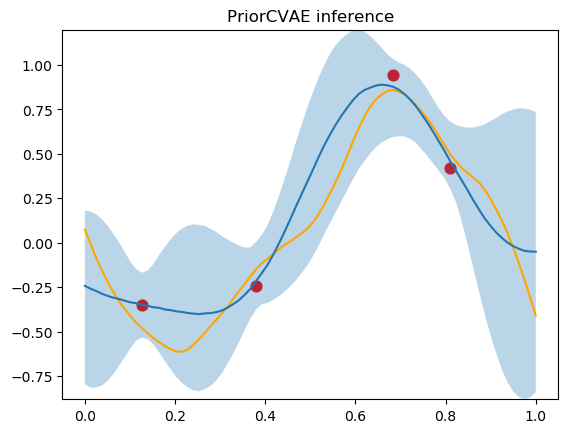

In [14]:
predictions_vae = mcmc_vae_samples["f"]

mean_post_pred_vae = jnp.mean(predictions_vae, axis=0)
hpdi_post_pred_vae = hpdi(predictions_vae, 0.9)
percentiles_vae = np.percentile(predictions_vae, [5.0, 95.0], axis=0)

N_lines = 10

# plt.figure(figsize=(10, 3))
plt.plot(x, gp_draw, label="ground truth", color="orange")
plt.scatter(x_obs, y_obs, color="red", label="observed data", s=60)
plt.title('Ground truth, corresponds to $ls$=' + str(true_ls))

plt.plot(x, mean_post_pred_vae, label="predicted mean VAE")
plt.fill_between(x, percentiles_vae[0, :], percentiles_vae[1, :], alpha=0.3, interpolate=True, 
                 label="VAE posterior: 90% BCI")

y_min = min(np.concatenate([y_obs, mean_post_pred_vae, percentiles_vae[0, :]]))
y_max = max(np.concatenate([y_obs, mean_post_pred_vae, percentiles_vae[1, :]]))

plt.ylim([y_min, y_max])

plt.title('PriorCVAE inference')

In [17]:
if conditional:
    c_samps = mcmc_vae_samples['c'].reshape((-1,))
    plt.hist(c_samps, density=True, label = 'PriorCVAE', bins=20, color='#ff7f0e', alpha=0.5)
    plt.vlines(true_ls, 0, 10, color="black")

    plt.ylim([0, 6])
    plt.show()
else:
    c_samps = None

In [18]:
ss = numpyro.diagnostics.summary(mcmc_vae.get_samples(group_by_chain=True))
r = np.mean(ss['f']['n_eff'])
print("Average ESS for all VAE-GP effects : " + str(round(r)))

Average ESS for all VAE-GP effects : 9673


## Saving

In [19]:
# gp_draw, y_draw, obs_idx, x, true_ls, mcmc_vae_samples, t_elapsed
if conditional:
    subdir_name = "PriorCVAE_MCMC"
else:
    subdir_name = "PriorVAE_MCMC"

output_mcmc_dir = os.path.join(output_dir, subdir_name)

if not os.path.exists(output_mcmc_dir):
    os.makedirs(output_mcmc_dir)

np.savez(os.path.join(output_mcmc_dir, "mcmc_stats.npz"), gp_draw=gp_draw, y_draw=y_draw, obs_idx=obs_idx, x=x,
        true_ls=true_ls, t_elapsed=t_elapsed, ess=r)

In [20]:
with open(os.path.join(output_mcmc_dir, "mcmc_samples.pkl"), 'wb') as f:
    pickle.dump(mcmc_vae_samples, f)